# Election forecasting with hierarchical regression

This notebook explores a hierarchical linear model for election forecasting in the US presidential election.

In [1]:
import numpy as np, scipy as sp, pymc3 as pm, arviz as az, matplotlib.pyplot as plt, pandas as pd, theano, theano.tensor as tt
from sklearn.preprocessing import OneHotEncoder

## Prologue: an unstructured model

As a first attempt, and to demonstrate the necessity of a model with additional structure, we fit a multiple regression model, pooling all observations to predict the Democratic vote share in each US state in 1992.

In [2]:
df = pd.read_csv('presidential.csv', delimiter=' ').dropna()
train = df[df['year'] < 1992]
test = df[df['year'] == 1992]

In [3]:
train.head()

,dvote,year,state,evotes,constant,n1,n2,n3,n4,s1,...,s6,s7,s8,s9,r1,r2,r3,r4,r5,r6
50,0.403,1988,1,9,1,0.4556,-0.48,0.0,-0.76,-0.021,...,-0.314567,-0.5169,0.065182,0.0,0,0,0,0,0,0
51,0.377,1988,2,3,1,0.4556,-0.48,0.0,-0.76,-0.099,...,5.485433,0.2181,-0.288815,0.0,0,0,0,0,0,0
52,0.393,1988,3,7,1,0.4556,-0.48,0.0,-0.76,-0.079,...,-1.014567,-0.3627,-0.253641,0.0,0,0,0,0,0,0
53,0.428,1988,4,6,1,0.4556,-0.48,0.0,-0.76,-0.020,...,2.785433,-0.2121,0.069746,0.0,0,0,0,0,0,0
54,0.482,1988,5,47,1,0.4556,-0.48,0.0,-0.76,0.043,...,-0.314567,0.1496,0.043126,0.0,0,0,0,0,0,0


#### Helper function for setting up the model

It's helpful to have a helper function to set up the model; this allows the model to be a function of the data we supply it. This is useful for holding out the testing data but still being able to predict on it later.

In [4]:
def setup_pooled_model(df):
    with pm.Model() as model:
        # Prior for model parameters
        alpha = pm.Normal('alpha', 0, 0.2)
        sigma = pm.HalfCauchy('sigma', 5)
    
        nation = theano.shared(df.loc[:,'n1':'n4'].values)
        state = theano.shared(df.loc[:,'s1':'s9'].values)
        region = theano.shared(df.loc[:,'r1':'r6'].values)
    
        b_nation = pm.Normal('b_nation', 0, 1, shape = 4)
        b_state = pm.Normal('b_state', 0, 1, shape = 9)
        b_region = pm.Normal('b_region', 0, 1, shape = 6)
    
        mu = pm.Deterministic('mu', alpha + tt.dot(nation, b_nation) + tt.dot(state, b_state) + tt.dot(region, b_region))
        y = pm.Normal('y', mu, sigma, observed=df.dvote)
    return model

In [5]:
# Fit the fully pooled model
with setup_pooled_model(train) as pooled_model:    
    pooled_train_trace = pm.sample(cores=4, tune=1000, target_accept = 0.9)
    summary = pm.summary(pooled_train_trace, var_names=['alpha', 'b_nation', 'b_state', 'b_region'])
    mu_vals = pm.summary(pooled_train_trace, var_names=['mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_region, b_state, b_nation, sigma, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:20<00:00, 298.71draws/s]


In [6]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.306,0.014,0.277,0.331,0.000,0.000,929.0,926.0,929.0,1188.0,1.00
b_nation[0],0.363,0.030,0.309,0.421,0.001,0.001,898.0,898.0,896.0,1308.0,1.00
b_nation[1],-0.017,0.006,-0.029,-0.007,0.000,0.000,1261.0,1235.0,1262.0,1343.0,1.00
b_nation[2],0.053,0.009,0.035,0.070,0.000,0.000,1100.0,1097.0,1097.0,1349.0,1.01
b_nation[3],0.026,0.002,0.022,0.029,0.000,0.000,1616.0,1616.0,1629.0,1536.0,1.00
b_state[0],0.298,0.036,0.231,0.364,0.001,0.001,1601.0,1599.0,1608.0,1451.0,1.00
b_state[1],0.254,0.030,0.200,0.311,0.001,0.001,1685.0,1674.0,1683.0,1596.0,1.00
b_state[2],0.037,0.009,0.022,0.054,0.000,0.000,2349.0,2246.0,2337.0,1362.0,1.00
b_state[3],0.017,0.008,0.002,0.033,0.000,0.000,2403.0,1955.0,2419.0,1482.0,1.00
b_state[4],0.038,0.010,0.019,0.057,0.000,0.000,1556.0,1518.0,1560.0,1490.0,1.00


#### A posterior predictive check

In [7]:
# Replicate the posterior predictive check from BDA section 15.2

def make_pooled_ppc(train_trace, train):
    # Sample from the posterior predictive distribution for each year
    reps_dict = {}
    for year in np.arange(1948, 1992, 4):
        with setup_pooled_model(train[train.year == year]) as test_model: 
            ppc = pm.sample_posterior_predictive(train_trace)
            reps_dict[year] = ppc['y']
    
    # Calculate residuals: replications vs. observations
    rep_resid = {}
    pred_resid = {}
    nrep = reps_dict[1948].shape[0]
    for year in np.arange(1948, 1992, 4):
        thisyear_dvote = np.tile(train[train.year == year]['dvote'], (2000,1))
        rep_resid[year] = reps_dict[year][:, :] - train_trace['mu'][:,train.year == year]
        pred_resid[year] = thisyear_dvote - train_trace['mu'][:,train.year == year]
    
    # Mean squared residuals
    sq_rep_resid_array = np.array([np.average(rep_resid[year], axis = 1) ** 2 for year in np.arange(1948, 1992, 4)])
    sq_pred_resid_array = np.array([np.average(pred_resid[year], axis = 1) ** 2 for year in np.arange(1948, 1992, 4)])
    
    # Final test statistics
    trep = np.sqrt(np.sum(sq_rep_resid_array, axis = 0))
    t = np.sqrt(np.sum(sq_pred_resid_array, axis = 0))
    
    #Make the plot
    plt.plot(t, trep, '.', color = 'blue', alpha = 0.3)
    plt.plot(np.linspace(0, 0.05, 5), np.linspace(0, 0.05, 5), color = 'red')
    plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1070.54it/s]


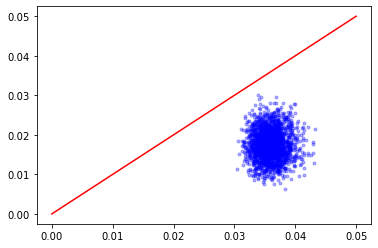

In [8]:
make_pooled_ppc(pooled_train_trace, train)

## A hierarchical model

Now we use a hierarchical model that introduces extra parameters for modeling a nationwide partisan shift in any given election year. These parameters are drawn from a common hyperprior distribution with fixed mean 0 and variance learned from the data (partial pooling).

In [9]:
def setup_hierarchical_model(df, year_enc):     # year-enc is the year variable, encoded into indicator variables
    with pm.Model() as model:
        alpha = pm.Flat('alpha')
        #sigma = pm.HalfCauchy('sigma', 5)
        #tau_delta = pm.HalfCauchy('tau_delta', 5)
        sigma = pm.Flat('sigma')
        tau_delta = pm.Flat('tau_delta')
        
        year = theano.shared(year_enc)
        data_X = theano.shared(df.loc[:,'n1':'r6'].values)
        beta = pm.Normal('beta', 0, 1, shape = 19)
        delta = pm.Normal('delta', 0, tau_delta, shape = 11)
        
        mu = pm.Deterministic('mu', alpha + tt.dot(data_X, beta) + tt.dot(year_enc, delta) )
        y = pm.Normal('y', mu, sigma, observed=df.dvote)
    return model

In [10]:
# Make year data tensors, encoded as indicator variables for each year
train_year_enc = OneHotEncoder().fit_transform(train[['year']]).toarray()
test_year_enc = OneHotEncoder().fit_transform(df[['year']]).toarray()[df.year == 1992, :]

# Sample the model
with setup_hierarchical_model(train, train_year_enc) as hierarchical_model:
    hier_train_trace = pm.sample(1000, cores = 4, tune = 1000, target_accept = 0.9)
    hier_summary = pm.summary(hier_train_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, beta, tau_delta, sigma, alpha]
Sampling 4 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]

ValueError: Not enough samples to build a trace.

In [ ]:
def make_hierarchical_ppc(train_trace, train, train_year_enc):
    # Sample the posterior predictive distribution
    reps_dict = {}
    for year in np.arange(1948, 1992, 4):
        with setup_hierarchical_model(train[train.year == year], train_year_enc[np.array(train.year == year), :]) as test_model: 
            ppc = pm.sample_posterior_predictive(train_trace)
            reps_dict[year] = ppc['y']
    
    # Calculate residuals
    rep_resid = {}
    pred_resid = {}
    nrep = reps_dict[1948].shape[0]
    for year in np.arange(1948, 1992, 4):
        thisyear_dvote = np.tile(train[train.year == year]['dvote'], (4000,1))
        rep_resid[year] = reps_dict[year][:, :] - train_trace['mu'][:,train.year == year]
        pred_resid[year] = thisyear_dvote - train_trace['mu'][:,train.year == year]
    
    # Mean squared residuals
    sq_rep_resid_array = np.array([np.average(rep_resid[year], axis = 1) ** 2 for year in np.arange(1948, 1992, 4)])
    sq_pred_resid_array = np.array([np.average(pred_resid[year], axis = 1) ** 2 for year in np.arange(1948, 1992, 4)])
    
    # Final test statistics
    trep = np.sqrt(np.average(sq_rep_resid_array, axis = 0))
    t = np.sqrt(np.average(sq_pred_resid_array, axis = 0))
    
    # Make the plot
    plt.plot(t, trep, '.', color = 'blue', alpha = 0.3)
    plt.plot(np.linspace(0, 0.02, 5), np.linspace(0, 0.02, 5), color = 'red')
    plt.show()

In [ ]:
make_hierarchical_ppc(hier_train_trace, train, train_year_enc)

## Forecasting from the models

When it comes to actually make a forecast, the posterior predictive distribution comes in again. How can we make these forecasts? What do they look like, and how are they different for the two models?

In [ ]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL',
          'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA',
          'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE',
          'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR',
          'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
          'WA', 'WV', 'WS', 'WY']

def make_pooled_forecast(train_trace, test):
    with setup_pooled_model(test) as simple_model:
        predictions = pm.sample_posterior_predictive(train_trace)
    return predictions

In [ ]:
pooled_forecast = make_pooled_forecast(pooled_train_trace, test)

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(2000):
    plt.plot(np.arange(1, 51), pooled_forecast['y'][i,:], '.', color = 'blue', alpha = 0.02)
plt.xticks(np.arange(1, 51), labels = states, rotation = 45)
plt.title('Vote share forecasts from the pooled model')
plt.plot(np.arange(1, 51), test['dvote'], 'o', color = 'red', label = 'Actual vote share in 1992')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(1000):
    plt.plot(np.arange(1, 51), hierarchical_forecast['y'][i,:], '.', color = 'blue', alpha = 0.02)
plt.xticks(np.arange(1, 51), labels = states, rotation = 45)
plt.title('Vote share forecasts from the hierarchical model')
plt.plot(np.arange(1, 51), test['dvote'], 'o', color = 'red', label = 'Actual vote share in 1992')
plt.legend()
plt.show()

In [ ]:
hier_summary[1:13]

In [ ]:
pooled_percentiles = np.zeros(50)
hier_percentiles = np.zeros(50)
for i in range(50):
    pooled_percentiles[i] = sum(pooled_forecast['y'][:, i] < test['dvote'][i]) / 2000
    hier_percentiles[i] = sum(hierarchical_forecast['y'][:, i] < test['dvote'][i]) / 4000
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 51), pooled_percentiles, 'o', markeredgecolor = 'black', markerfacecolor='none', label = 'pooled model percentiles')
plt.plot(np.arange(1, 51), hier_percentiles, 'o', color = 'black', label = 'hierarchical model percentiles')
plt.xticks(np.arange(1, 51), labels = states, rotation = 45)
plt.legend()
plt.show()

In [ ]:
az.compare({'pooled':pooled_train_trace, 'hierarchical':hier_train_trace}, ic = 'WAIC')

In [ ]:
az.compare({'pooled':pooled_train_trace, 'hierarchical':hier_train_trace}, ic = 'loo')

## Nationwide election forecast

In [ ]:
# Compute electoral votes for each draw from the posterior predictive distribution
plt.hist(np.sum((pooled_forecast['y'] >= 0.5) * np.tile(df.evotes[0:50], (2000,1)), axis = 1), bins = np.arange(200, 500, 10), density=True, edgecolor = 'black', alpha = 0.3)
plt.vlines(x=270, ymin=0, ymax=0.01, color = 'red', lw = 1, linestyle='--', label = 'Winning number')
plt.vlines(x=370, ymin=0, ymax=0.01, color = 'red', lw = 2, label = 'True count')
plt.legend()

In [ ]:
# Compute electoral votes for each draw from the posterior predictive distribution
plt.hist(np.sum((hierarchical_forecast['y'] >= 0.5) * np.tile(df.evotes[0:50], (4000,1)), axis = 1), bins = np.arange(50, 540, 10), density=True, edgecolor = 'black', alpha = 0.3)
plt.vlines(x=270, ymin=0, ymax=0.01, color = 'red', lw = 1, linestyle='--', label = 'Winning number')
plt.vlines(x=370, ymin=0, ymax=0.01, color = 'red', lw = 2, label = 'True count')
plt.legend()